# Data Preparation

In [1003]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline
pd.set_option('display.max_columns', None)

In [1004]:
df = pd.read_csv('factbook_tr.csv')

In [1005]:
df = df[['Exports', 'Imports', 'Industrial production growth rate', 'Investment', 'Unemployment rate']]
df.head()

,Exports,Imports,Industrial production growth rate,Investment,Unemployment rate
0,538800000000,401800000000,6.6,24.0,4.7
1,893300000000,716700000000,2.2,17.6,10.6
2,113000000000,36210000000,2.8,17.2,25.0
3,162500000000,92910000000,6.4,19.1,8.3
4,130700000000,121100000000,4.7,20.4,3.4


In [1006]:
df['Trade balance'] = df['Exports'] - df['Imports']
df['Economic performance'] = (df['Industrial production growth rate'] + df['Investment'] + df['Unemployment rate'])
df.head()

,Exports,Imports,Industrial production growth rate,Investment,Unemployment rate,Trade balance,Economic performance
0,538800000000,401800000000,6.6,24.0,4.7,137000000000,35.3
1,893300000000,716700000000,2.2,17.6,10.6,176600000000,30.4
2,113000000000,36210000000,2.8,17.2,25.0,76790000000,45.0
3,162500000000,92910000000,6.4,19.1,8.3,69590000000,33.8
4,130700000000,121100000000,4.7,20.4,3.4,9600000000,28.5


In [1007]:
df = df[['Trade balance', 'Economic performance']]
df.head()

,Trade balance,Economic performance
0,137000000000,35.3
1,176600000000,30.4
2,76790000000,45.0
3,69590000000,33.8
4,9600000000,28.5


# Data Normalization

In [1008]:
# Membuat fungsi min-max scaler
def minMax_scaler(df):
    return (df - df.min()) / (df.max() - df.min())

In [1009]:
df = df.apply(minMax_scaler)
df.head()

,Trade balance,Economic performance
0,0.953825,0.318018
1,1.000000,0.273874
2,0.883617,0.405405
3,0.875222,0.304505
4,0.805271,0.256757


# Define Function

In [1010]:
# Membuat centroid secara random
def random_centroid(df, k):
    random_idx = [np.random.randint(len(df)) for _ in range(k)]
    centroids = []
    for i in random_idx:
        centroids.append(df.iloc[i])
    return centroids

In [1011]:
# Mendefinisikan cluster menggunakan euclidean distance
def assign_cluster(df, initial_centroid, k):
    cluster = []
    for i in range(len(df)):
        euclidean_distance = []
        for j in range(k):
            euclidean_distance.append(np.linalg.norm(np.subtract(df.iloc[i], initial_centroid[j])))
        cluster.append(np.argmin(euclidean_distance))
    return cluster

In [1012]:
# Menghitung centroid hingga konvergen
def compute_centroid(df, cluster, k):
    centroids = []
    for i in range(k):
        temp = []
        for j in range(len(df)):
            if cluster[j] == i:
                temp.append(df.iloc[j])
        centroids.append(np.mean(temp, axis=0))
    return centroids

In [1013]:
# Menghitung perbedaan centroid lama dan centroid baru
def difference(old, new):
    diff = 0
    for i in range(len(old)):
        diff += np.linalg.norm(np.subtract(old[i], new[i]))
    return diff

# K-Means Clustering

In [1014]:
# Menampilkan cluster dan centroid
def show_cluster(df, cluster, k):
    df['cluster'] = cluster
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x='Trade balance',
                    y='Economic performance',
                    hue='cluster',
                    data=df,
                    palette='Set1')
    plt.title(f'K-Means Clustering (k={k})')
    for i in range(k):
        plt.scatter(x=df[df['cluster'] == i]['Trade balance'].mean(),
                    y=df[df['cluster'] == i]['Economic performance'].mean(),
                    s=200, c='black', marker='*')
    plt.show()

In [1015]:
# Memanggil fungsi k-means
def k_means(df, k):
    initial_centroid = random_centroid(df, k)
    cluster = assign_cluster(df, initial_centroid, k)
    new_centroid = compute_centroid(df, cluster, k)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, k)
        new_centroid = compute_centroid(df, cluster, k)
    show_cluster(df, cluster, k)

# Inertia with Elbow Method

In [1016]:
# Menghitung inertia untuk setiap cluster
def inertia(df, cluster, k):
    inertia = []
    for i in range(k):
        temp = []
        for j in range(len(df)):
            if cluster[j] == i:
                temp.append(df.iloc[j])
        inertia.append(np.sum(np.linalg.norm(np.subtract(temp, np.mean(temp, axis=0)), axis=1)))
    return np.sum(inertia)

In [1017]:
# Menghitung nilai inertia untuk setiap k
def k_means_inertia(df, n_cluster):
    initial_centroid = random_centroid(df, n_cluster)
    cluster = assign_cluster(df, initial_centroid, n_cluster)
    new_centroid = compute_centroid(df, cluster, n_cluster)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, n_cluster)
        new_centroid = compute_centroid(df, cluster, n_cluster)
    return inertia(df, cluster, n_cluster)

In [1018]:
for i in range(1, 6):
    print(f'Inertia k={i}: {k_means_inertia(df, i)}')

Inertia k=1: 17.120228497890615
Inertia k=2: 12.900327560841495
Inertia k=3: 9.610994465579813
Inertia k=4: 8.317356494998181
Inertia k=5: 7.576101599231637


In [1019]:
# Menampilkan grafik inertia untuk setiap k
def elbow_method(df, k):
    inertia_list = []
    for i in range(1, k+1):
        initial_centroid = random_centroid(df, i)
        cluster = assign_cluster(df, initial_centroid, i)
        new_centroid = compute_centroid(df, cluster, i)
        while difference(initial_centroid, new_centroid) > 0.001:
            initial_centroid = new_centroid
            cluster = assign_cluster(df, initial_centroid, i)
            new_centroid = compute_centroid(df, cluster, i)
        inertia_list.append(inertia(df, cluster, i))

    plt.figure(figsize=(8, 8))
    plt.plot(range(1, k+1), inertia_list, marker='o')
    for i, v in enumerate(inertia_list):
        plt.text(i+1, v, round(v, 2), ha='center', va='bottom')
    plt.xlabel('Number of cluster')
    plt.ylabel('Inertia')
    plt.show()

# Elbow Method and K-Means Visualization

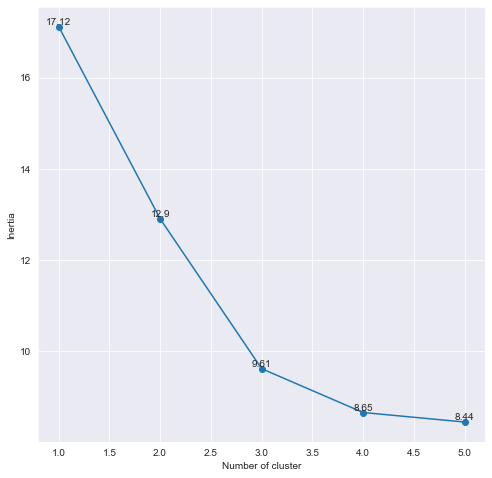

In [1020]:
elbow_method(df, 5)

Berdasarkan grafik diatas, dapat dilihat bahwa nilai inertia menurun drastis pada k=2 dan k=3. Oleh karena itu, nilai k yang digunakan adalah 3.

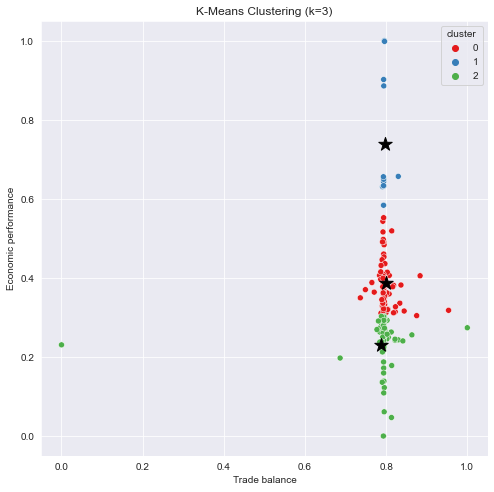

In [1021]:
k_means(df, 3)